<a href="https://colab.research.google.com/github/kentarokawamuraaaa/summarization-openai-python-promptflow/blob/main/quickstarts/Spatial_understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 2D spatial understanding with Gemini 2.0

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

In [3]:
%pip install -U -q google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 5.2 MB/s eta 0:00:00


In [4]:
from google.colab import userdata
import os

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [5]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

In [6]:
model_name = "gemini-2.5-pro-preview-05-06" # @param ["gemini-1.5-flash-latest","gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-flash-preview-05-20","gemini-2.5-pro-preview-05-06"] {"allow-input":true}

In [7]:
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
      """

In [8]:
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

In [9]:
import google.generativeai as genai
from PIL import Image

import io
import os
import requests
from io import BytesIO

In [10]:
# @title Parsing JSON output
def parse_json(json_output: str):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [11]:
# @title Plotting Util

# Get Noto JP font to display janapese characters
!apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

#!apt-get install fonts-source-han-sans-jp # For Source Han Sans (Japanese)

import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 3s (22.8 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126109 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


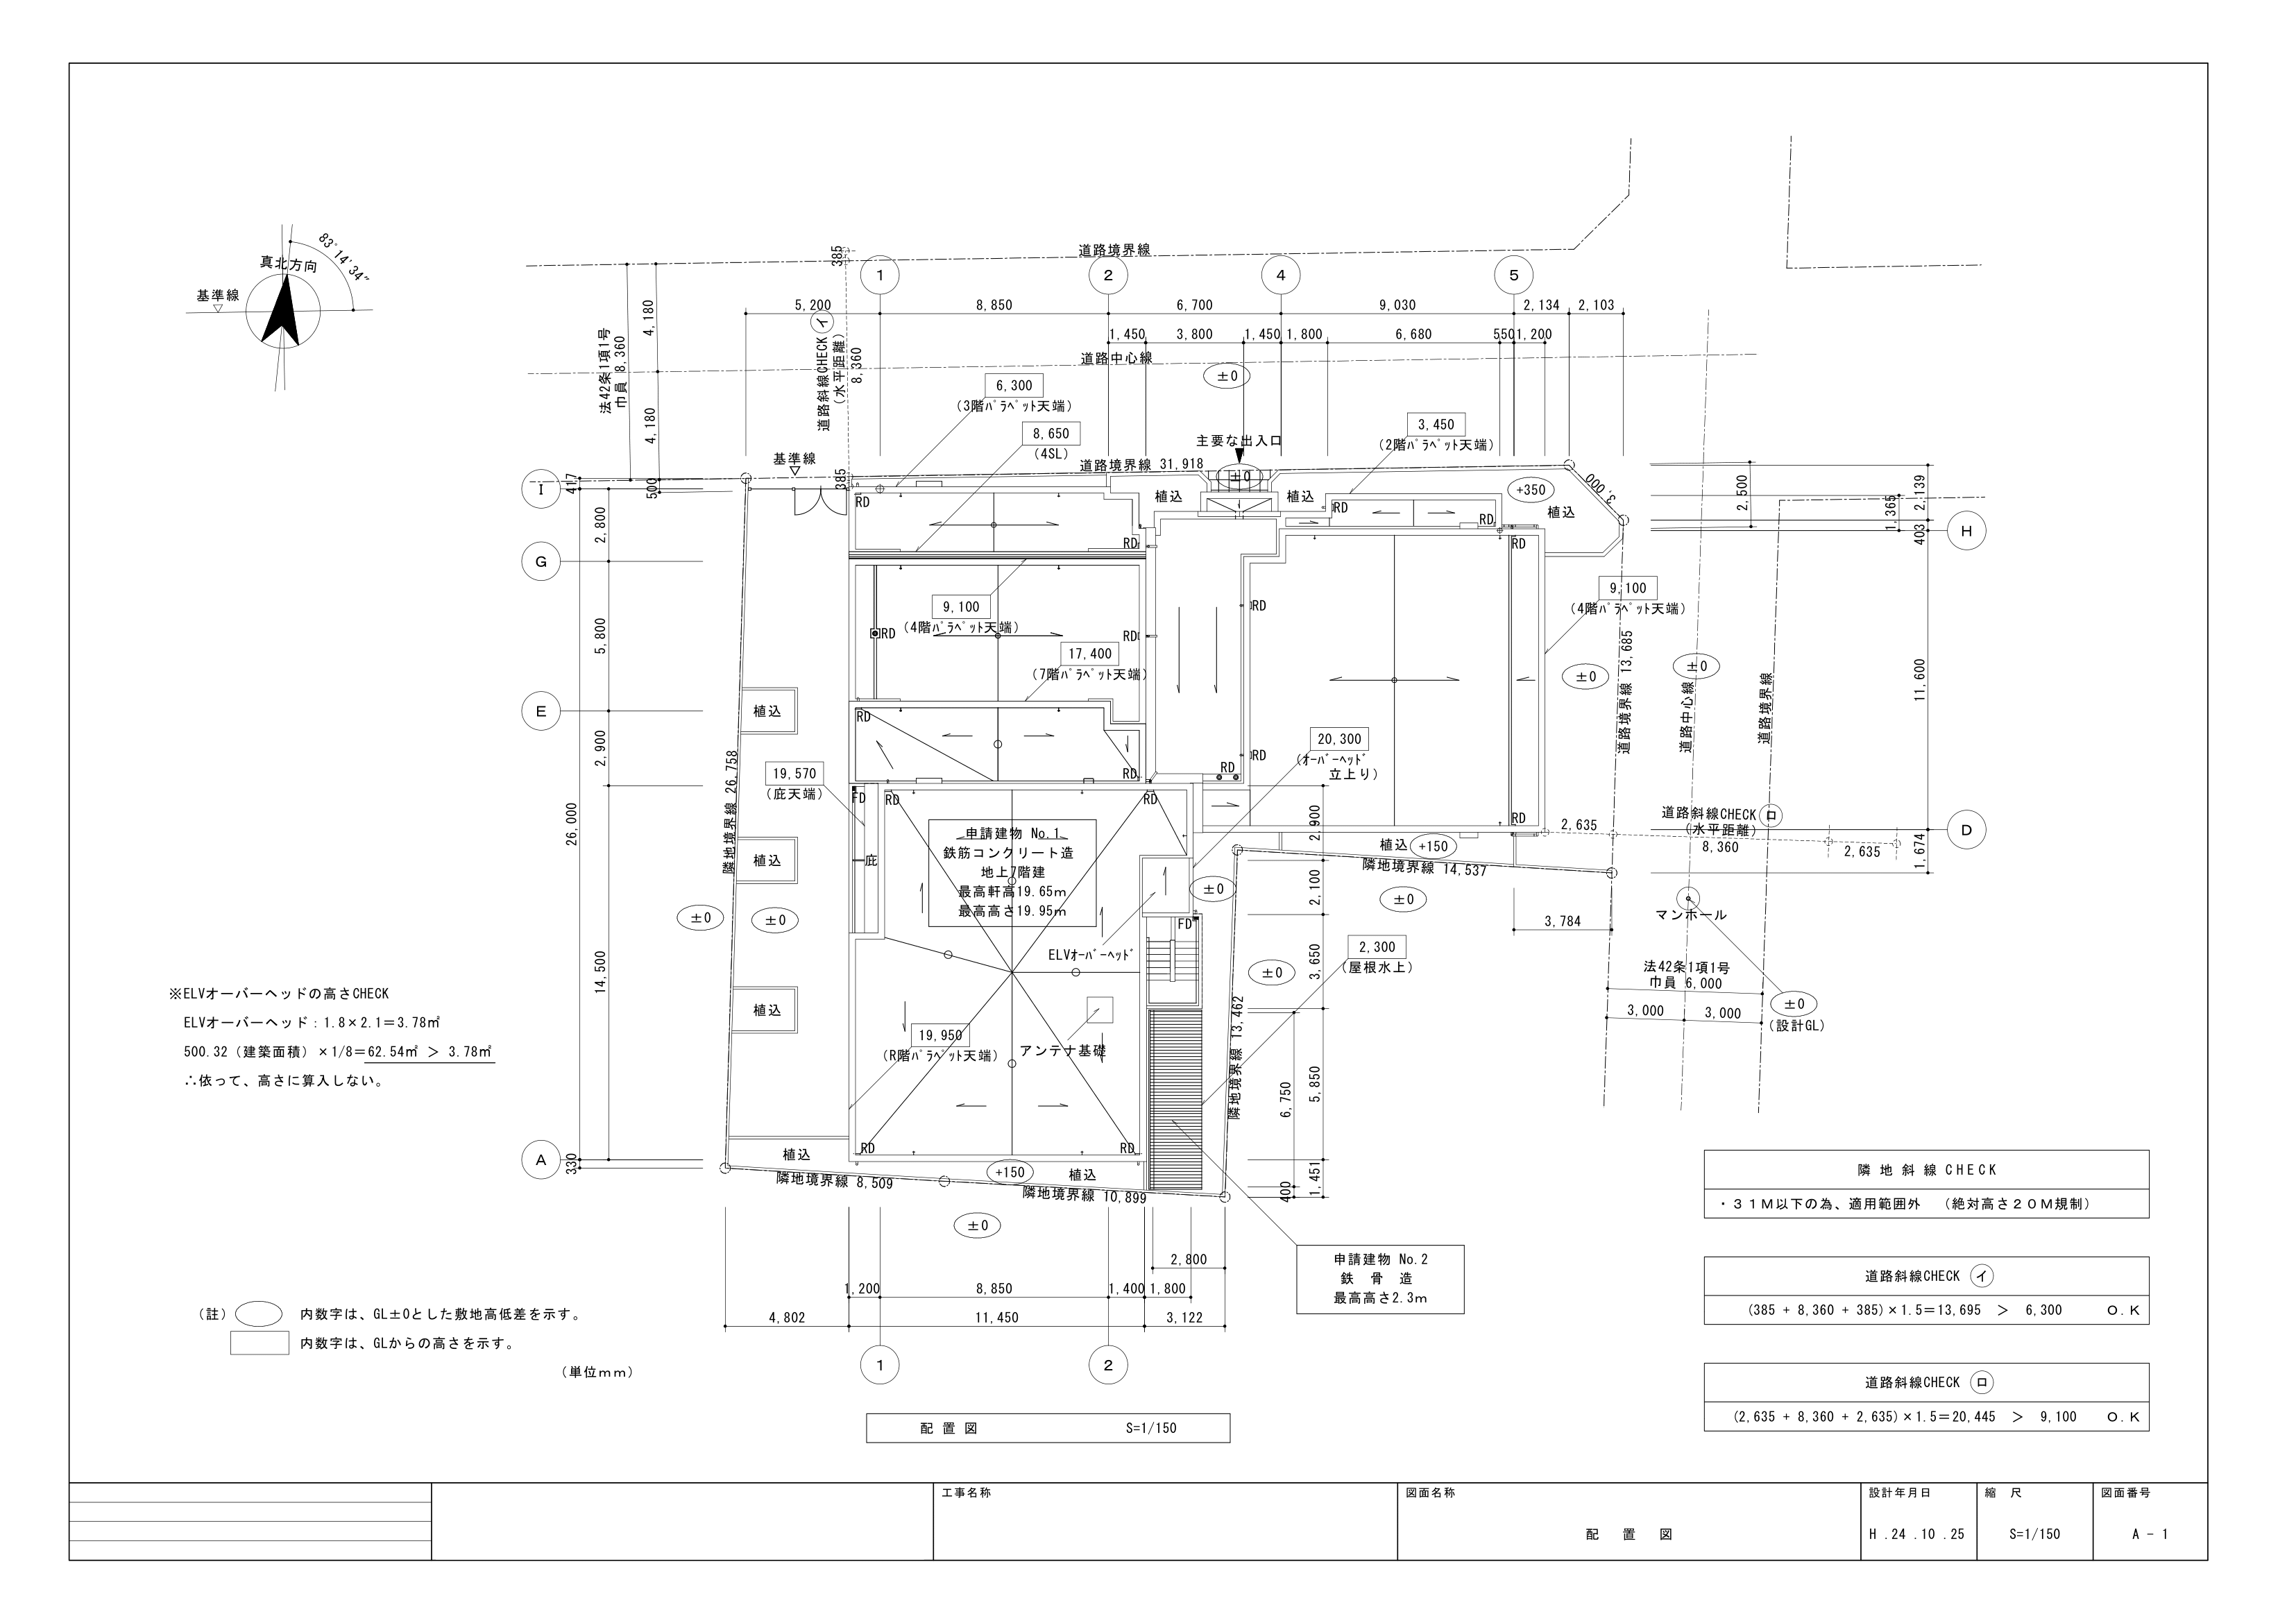

```json
[
  {"box_2d": [174, 306, 726, 333], "label": "adjacent property line (north-west)"},
  {"box_2d": [149, 325, 305, 501], "label": "road boundary line (north)"},
  {"box_2d": [178, 680, 516, 716], "label": "road boundary line (east)"},
  {"box_2d": [528, 531, 700, 623], "label": "adjacent property line (south-east)"},
  {"box_2d": [697, 331, 817, 529], "label": "adjacent property line (south-west)"}
]
```
(3309, 2339)


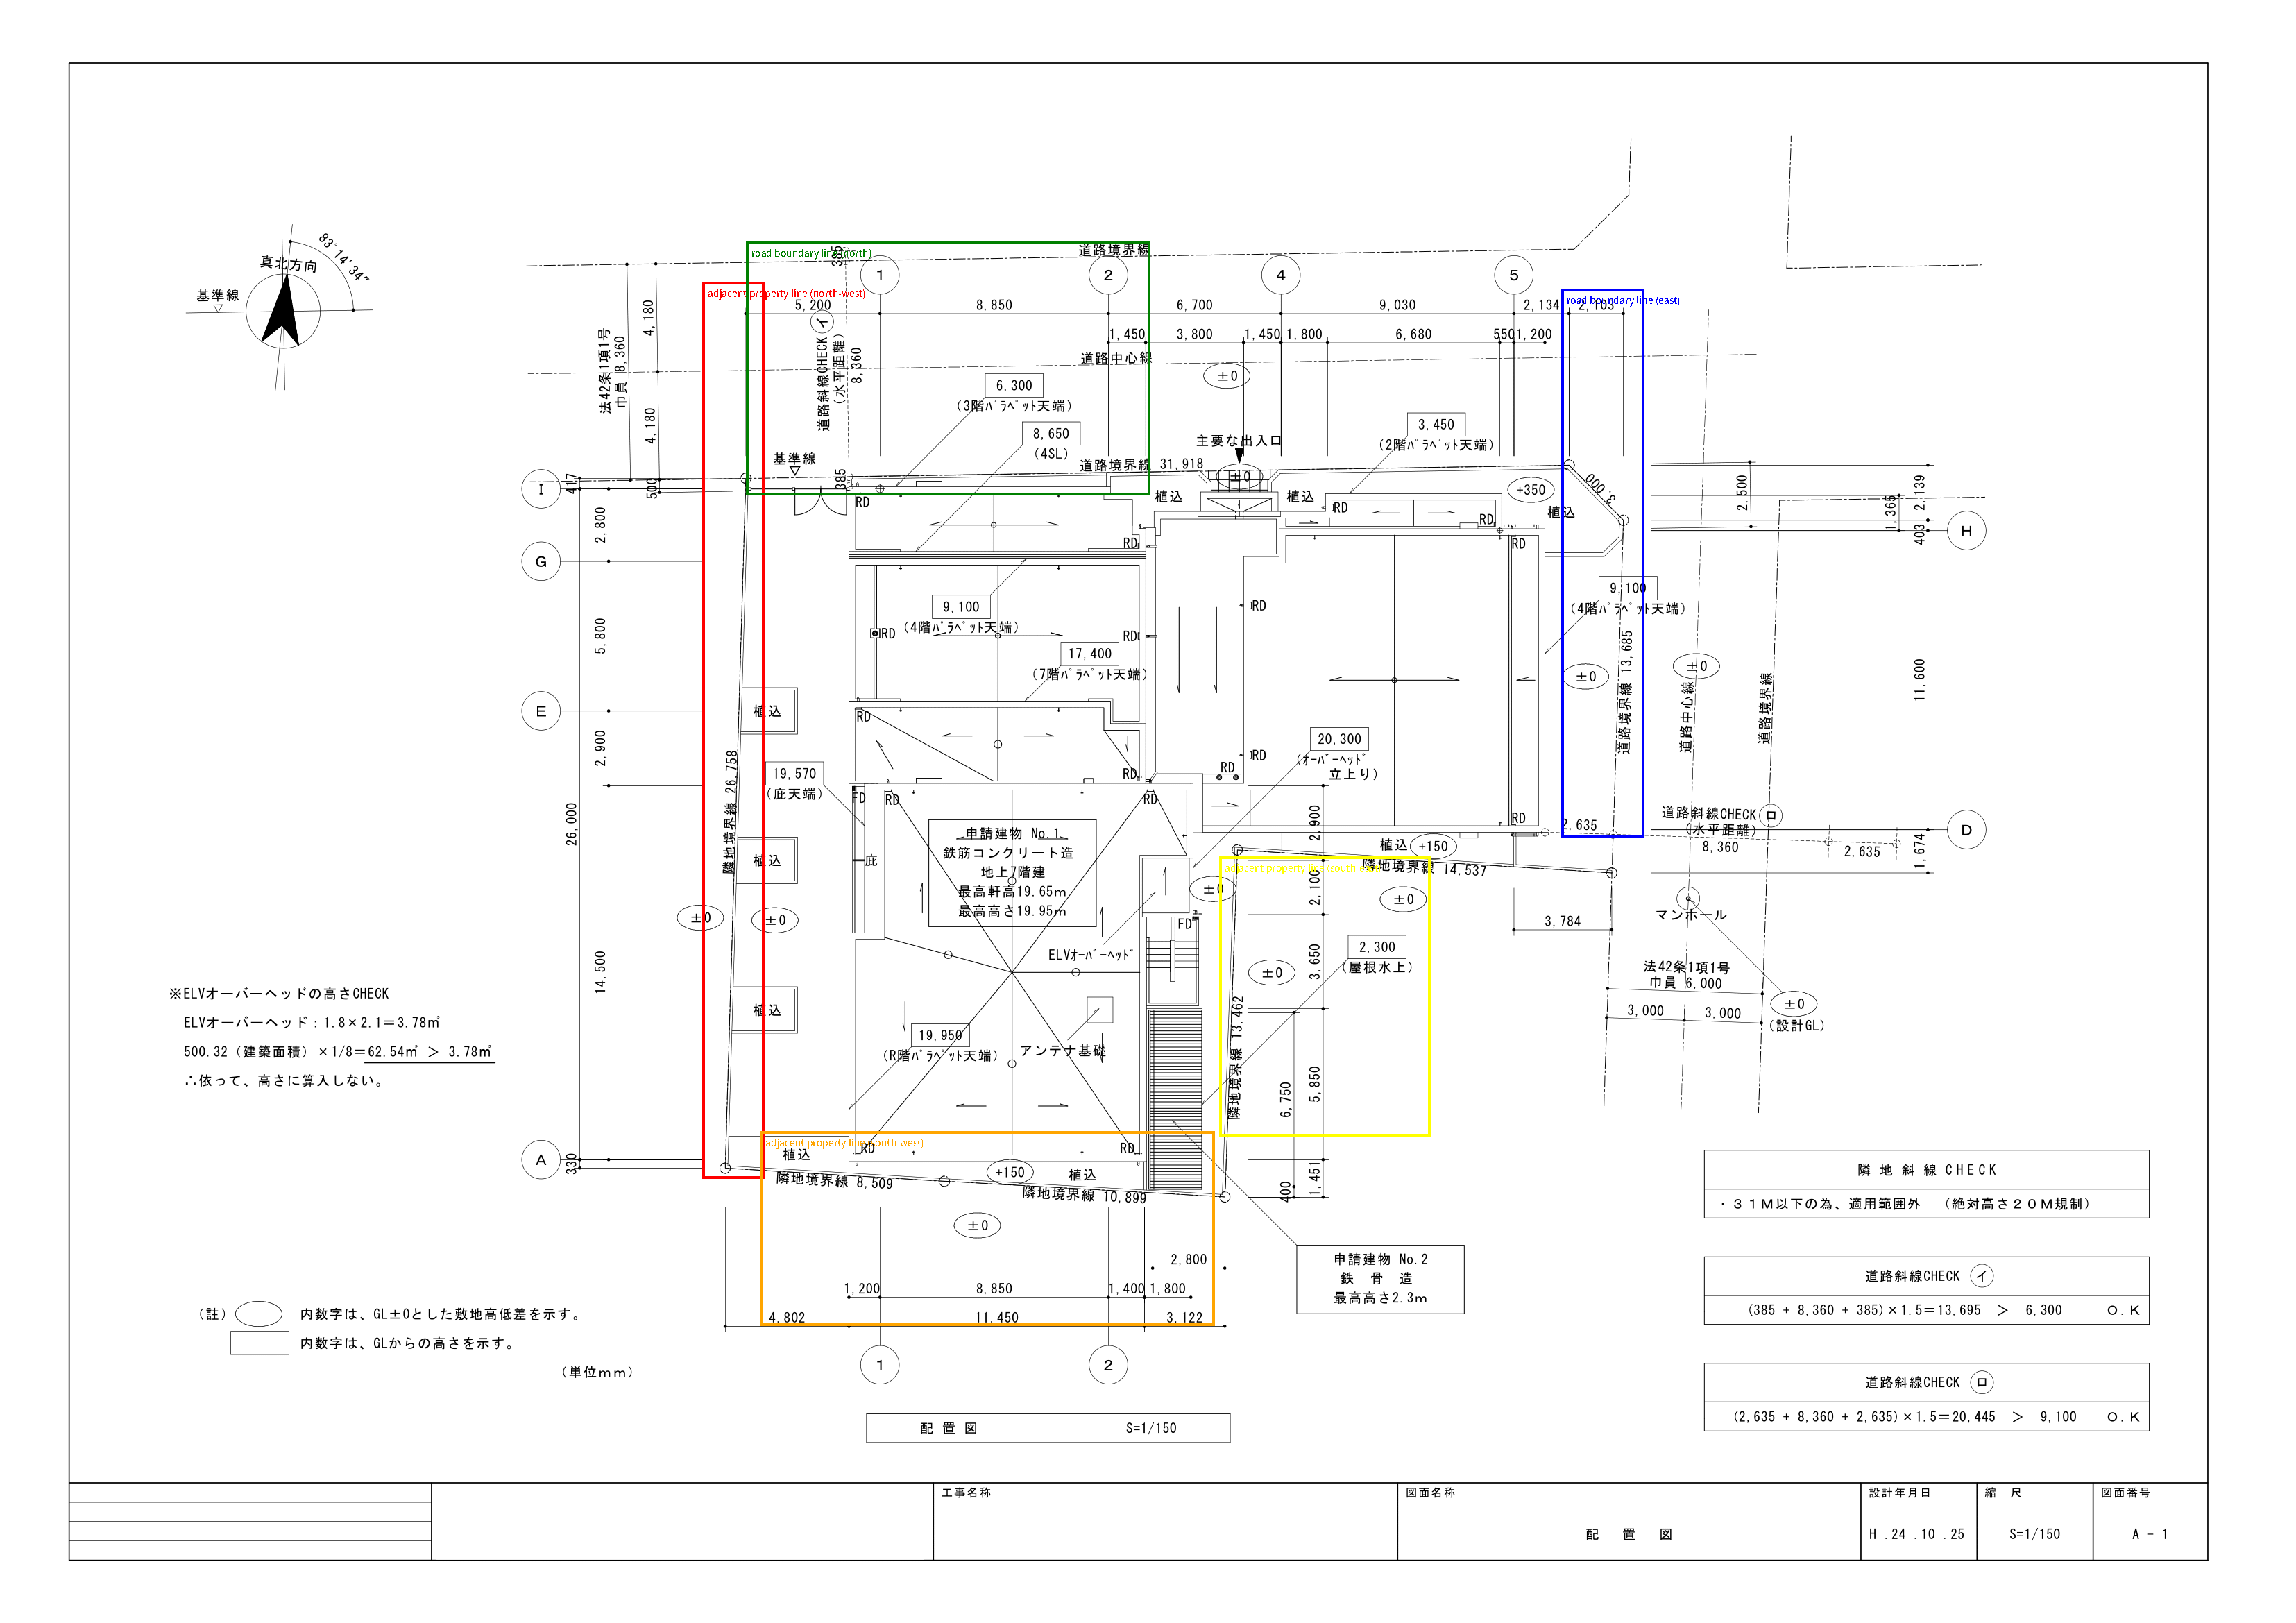

In [28]:
from PIL import Image
from IPython.display import display
from io import BytesIO

# === 設定項目 ===
image_path = "/content/aaaa-1.png"
prompt = "Detect the 2d bounding boxes of property_line(Is it described as adjacent property line, road boundary line, or site boundary, and is a straight line drawn in its immediate vicinity?) (with “label” as topping description)"

# === PNG画像読み込み==
with open(image_path, "rb") as f:
    original_image = Image.open(BytesIO(f.read()))

# 表示（Colab/Jupyter向け）
display(original_image)

# === モデル呼び出し ===
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, original_image],
    config=types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# === 結果表示 ===
print(response.text)
plot_bounding_boxes(original_image, response.text)
original_image